In [2]:
import os
import scipy.io
import numpy as np
import pandas as pd

# Set data folder path
DATA_FOLDER = r'D:/NUS_TERM2_CA3/MAREA_dataset'

ACTIVITY_FOLDER = os.path.join(DATA_FOLDER, 'Activity Timings')
SUBJECT_FOLDER = os.path.join(DATA_FOLDER, 'Subject_Data_txt_format')


###########################################################################
# treadWalk       = indoor_time['indoorTime'][:,1:2]
# treadIncline    = indoor_time['indoorTime'][:,4:5]
# treadWalknRun   = indoor_time['indoorTime'][:,1:3]
# indoorWalk      = indoor_time['indoorTime'][:,6:7]
# indoorRun       = indoor_time['indoorTime'][:,6:8]
# outdoorWalk     = outdoor_time['outdoorTime'][:,1:2]
# outdoorWalknRun = outdoor_time['outdoorTime'][:,1:3]
###########################################################################

###########################################################################
# Subject numbers 1 to 11 are involved in Indoor Experiments
# Subject numbers 12 to 20 are involved in Outdoor Experiments
###########################################################################

###########################################################################
# There are five Indoor Activity labels:
# actIndex = 1 -> treadWalk
# actIndex = 2 -> treadIncline
# actIndex = 3 -> treadWalknRun
# actIndex = 4 -> indoorWalk
# actIndex = 5 -> indoorWalknRun

# There are two Outdoor Activity labels:
# actIndex = 1 -> outdoorWalk
# actIndex = 2 -> outdoorWalknRun
###########################################################################

###########################################################################
# There are four accelerometer positions (accPos) to choose from:
# accPos = 1 -> Left Foot
# accPos = 2 -> Right Foot
# accPos = 3 -> Waist
# accPos = 4 -> Wrist
###########################################################################

In [3]:
# Define Activity Labels
indoor_label = ['tread_flat_walk_start', 
                'tread_flat_walk_end',
                'tread_flat_run_end',
                'tread_slope_walk_start',
                'tread_slope_walk_end',
                'indoor_flat_walk_start',
                'indoor_flat_walk_end',
                'indoor_flat_run_end'
               ]

outdoor_label = ['outdoor_walk_start',
                 'outdoor_walk_end',
                 'outdoor_run_end']

indoor_time_df = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Indoor Experiment Timings.txt')
                            , names= indoor_label)

outdoor_time_df = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Outdoor Experiment Timings.txt')
                            , names=outdoor_label)

indoor_time_df["subject"] = ["Sub" + str(i) for i in range(1, 12)]
outdoor_time_df["subject"] = ["Sub" + str(j) for j in range(12, 21)]

print(indoor_time_df)
print(outdoor_time_df)

    tread_flat_walk_start  tread_flat_walk_end  tread_flat_run_end  \
0                       1                55931               85681   
1                       1                40911               84991   
2                       1                62261               83961   
3                       1                45781               84551   
4                       1                63971               85121   
5                       1                69381               84781   
6                       1                46331               83761   
7                       1                53801               84811   
8                       1                69131               84661   
9                       1                70041               84941   
10                      1                77641               84741   

    tread_slope_walk_start  tread_slope_walk_end  indoor_flat_walk_start  \
0                   102181                180281                  223681   
1      

In [4]:
pos_list = ['LF','RF','Waist','Wrist']
sub_list = ["Sub" + str(i) for i in range(1, 21)]
sub_list.remove('Sub4')


In [7]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
import numpy as np
import pywt

def alsbase(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def denoise(signal_orig):
    coeffs_orig = pywt.wavedec(signal_orig, 'db4', level=2)
    coeffs_filter = coeffs_orig.copy()

    threshold = 0.8

    for i in range(1, len(coeffs_orig)):
        coeffs_filter[i] = pywt.threshold(coeffs_orig[i], threshold*max(coeffs_orig[i]))

    signal_denoised = pywt.waverec(coeffs_filter, 'db4')
    
    return signal_denoised

In [12]:
sub_list1 = ['Sub1']
new_names = ['accX_LF', 'accY_LF', 'accZ_LF', 
            'accX_RF', 'accY_RF', 'accZ_RF', 
             'accX_Waist', 'accY_Waist', 'accZ_Waist', 
             'accX_Wrist', 'accY_Wrist', 'accZ_Wrist'            
            ]

sub_df = None
for sub in sub_list1:
    lf_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'LF.txt'))
    rf_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'RF.txt'))
    waist_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Waist.txt'))
    wrist_df = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Wrist.txt'))
    sub_df = pd.concat([lf_df, rf_df, waist_df, wrist_df], axis=1)
    sub_df.columns = new_names
    print(sub_df.head())
    
    sub_df_new = sub_df.copy()
    for column in new_names:
        print(sub_df_new[column].values.shape)
        sub_df_new[column] = denoise(sub_df_new.values)
#         sub_df_new[column] = sub_df_new[column] - alsbase(sub_df_new[column], 10^5,0.000005,niter=10)

    sub_row = indoor_time_df[indoor_time_df['subject'] == sub]
    print(sub_row.loc[0])
#     print(sub_row.loc[0]['tread_flat_walk_end'])
    sub_df_new.loc[0:sub_row.loc[0]['tread_flat_walk_end'], 'label'] = 'tread_flat_walk'
    sub_df_new.loc[sub_row.loc[0]['tread_flat_walk_end']: sub_row.loc[0]['tread_flat_run_end'], 'label'] = 'tread_flat_run'
    sub_df_new.loc[sub_row.loc[0]['tread_flat_run_end']: sub_row.loc[0]['tread_slope_walk_start'], 'label'] = 'NA'
    sub_df_new.loc[sub_row.loc[0]['tread_slope_walk_start']: sub_row.loc[0]['tread_slope_walk_end'], 'label'] = 'tread_slope_walk'
    sub_df_new.loc[sub_row.loc[0]['tread_slope_walk_end']: sub_row.loc[0]['indoor_flat_walk_start'], 'label'] = 'NA'
    sub_df_new.loc[sub_row.loc[0]['indoor_flat_walk_start']: sub_row.loc[0]['indoor_flat_walk_end'], 'label'] = 'indoor_flat_walk'
    sub_df_new.loc[sub_row.loc[0]['indoor_flat_walk_end']: sub_row.loc[0]['indoor_flat_run_end'], 'label'] = 'indoor_flat_run'
        
    print(sub_df_new)

   accX_LF  accY_LF  accZ_LF  accX_RF  accY_RF  accZ_RF  accX_Waist  \
0   -2.196  -11.765   -1.569    4.078   -6.902    2.196      -0.157   
1   -2.510  -10.353   -2.039    4.392   -8.000    1.255      -0.157   
2   -2.353  -10.824   -2.510    4.863   -8.314    0.941      -0.157   
3   -1.882  -10.667   -2.667    4.549   -9.412   -0.157      -0.157   
4   -1.412  -10.353   -2.824    3.451  -10.353   -0.784      -0.627   

   accY_Waist  accZ_Waist  accX_Wrist  accY_Wrist  accZ_Wrist  
0      -8.157       0.784       0.941     -11.451      -2.510  
1      -8.000       1.255       0.627     -10.510      -2.353  
2      -7.843       1.255       0.784     -10.196      -2.039  
3      -8.000       1.412       1.255     -10.039      -1.412  
4      -7.529       1.882       1.569     -10.196      -1.255  
(271681,)


ValueError: Length of values does not match length of index

ConversionError: Failed to convert value(s) to axis units: array(['tread_flat_walk', 'tread_flat_walk', 'tread_flat_walk', ...,
       'indoor_flat_run', 'indoor_flat_run', 'indoor_flat_run'],
      dtype=object)

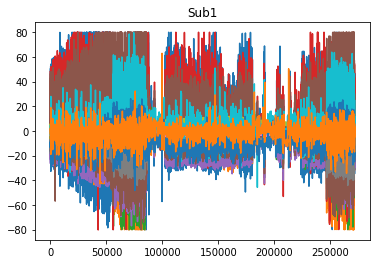

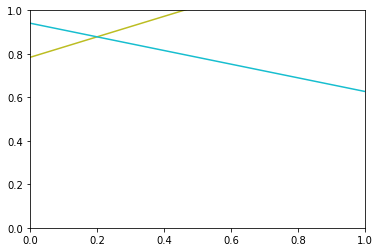

In [51]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sub_df)
# plt.legend(new_names)
plt.title('Sub1')

plt.figure()
plt.plot(sub_df_new)
# plt.legend(new_names)
plt.title('Sub1_new')

plt.figure()
